In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Challenge

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Challenge


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

from sklearn.preprocessing import LabelEncoder

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [3]:
dataset = np.load("training_data.npy")
valid = np.load("valid_periods.npy")

In [4]:
print(dataset.shape)

(48000, 2776)


In [5]:
X_min = dataset.min()
X_max = dataset.max()

X_train_raw = (dataset-X_min)/(X_max-X_min)

#### Display random series

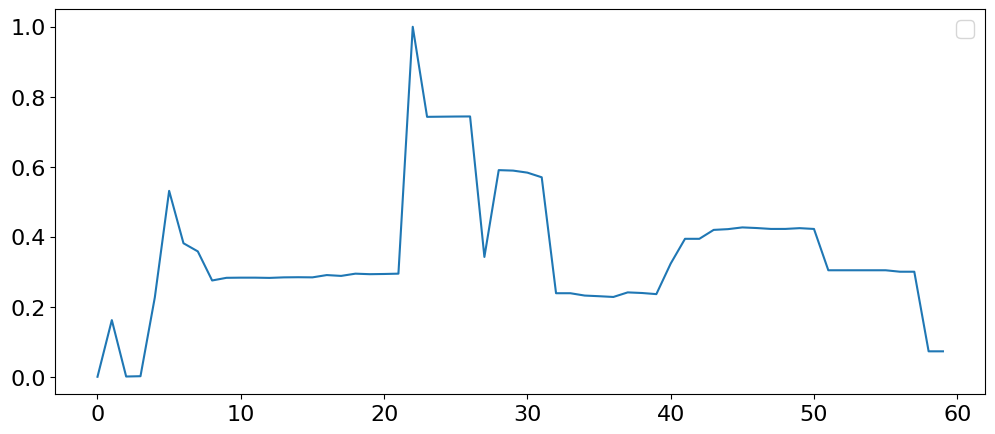

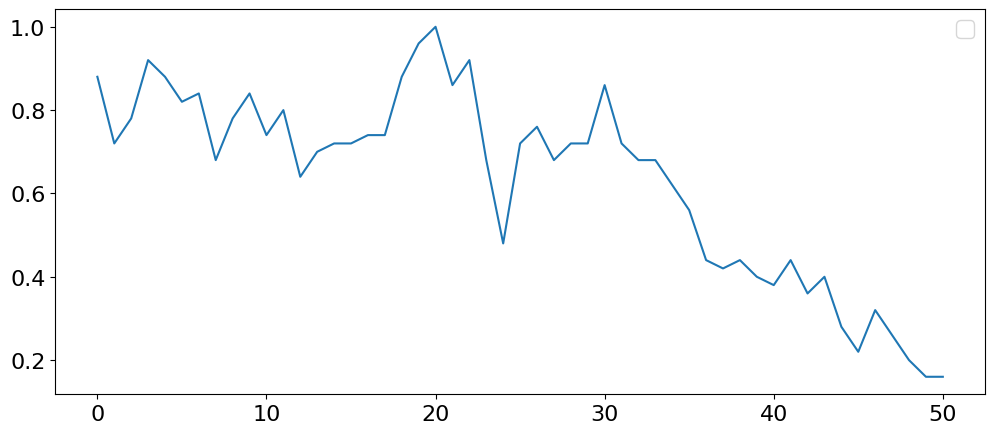

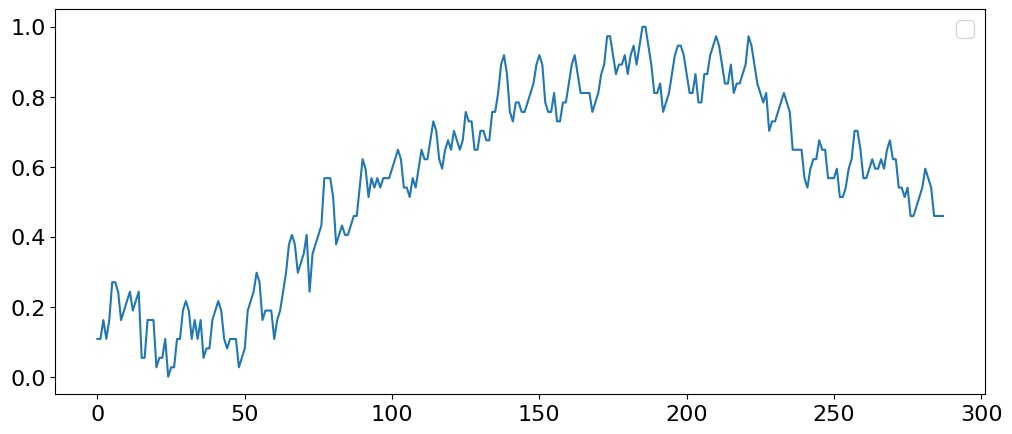

In [6]:
for i in range(3):
  index = random.randint(0, X_train_raw.shape[0])
  plt.figure(figsize=(12,5))
  plt.plot(X_train_raw[index, valid[index][0]:])
  plt.legend()
  plt.show()

### Sequences building

In [7]:
import pickle

def build_sequences(df, valid, window=50, stride=10, telescope=3):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    target = []

    for i, sample in enumerate(df):
      j = valid[i, 0]
      while (j + window + telescope < len(sample)):
        dataset.append(sample[j:j + window])
        target.append(sample[j + window:j + window + telescope])
        j += stride

    dataset = np.array(dataset)
    target = np.array(target)

    dataset = np.expand_dims(dataset, axis=2)
    target = np.expand_dims(target, axis=2)

    return dataset, target

In [8]:
X_train, y_train = build_sequences(X_train_raw, valid, window=50, telescope=3)
#X_val, y_val = build_sequences(X_val_raw, categories, valid)

In [16]:
print(X_train.shape)
print(y_train.shape)

(719516, 50, 1)
(719516, 3, 1)


#### Model building and training

In [10]:
def build_model(input_shape, output_shape, learning_rate=1e-3, units=[128, 128]):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x1 = tfkl.Bidirectional(tfkl.LSTM(units[0], return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x1 = tfkl.Conv1D(units[1], 3, padding='same', activation='relu', name='conv')(x1)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x1)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)


    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

    return model

In [11]:
models = [
    build_model(X_train.shape[1:], y_train.shape[1:], units=[128, 128]),
    #build_model(X_train.shape[1:], y_train.shape[1:], units=[256, 128]),
    #build_model(X_train.shape[1:], y_train.shape[1:], units=[256, 256])
]

In [ ]:
histories = []

for model in models:
  # Train the model
  histories.append(model.fit(
      x = X_train,
      y = y_train,
      batch_size = 256,
      epochs = 60,
      validation_split=.1,
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
      ]
  ).history)

0.004219092428684235
0.006739169824868441


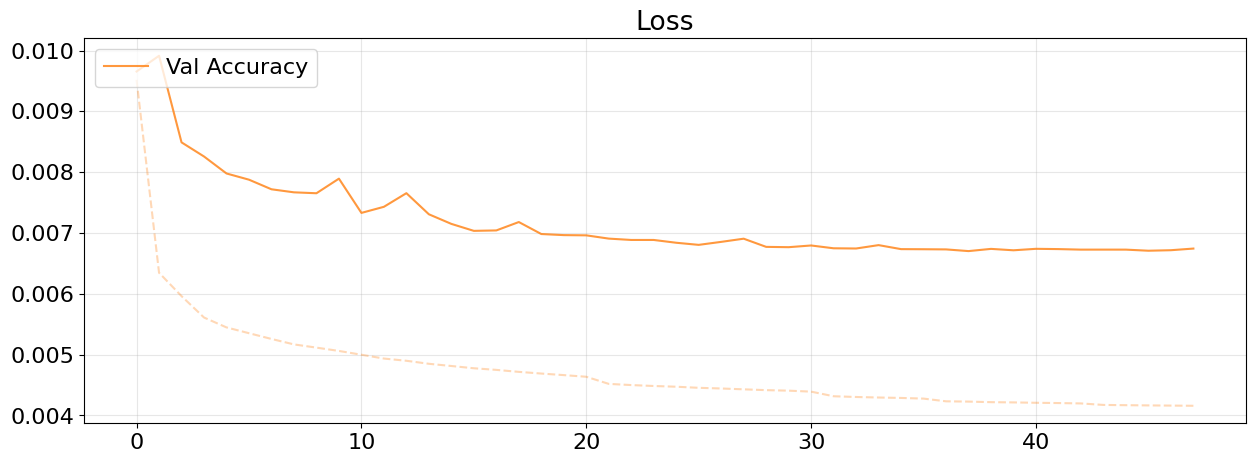

In [ ]:
for history in histories:
  print(history['loss'][-10])
  print(history['val_loss'][-10])
  plt.figure(figsize=(15,5))
  plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history['val_loss'], label='Val Accuracy', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Loss')
  plt.grid(alpha=.3)
  plt.show()

In [ ]:
models[0].save("model")
del models[0]

In [12]:
model = tfk.models.load_model("model")

In [13]:
X_val = X_train[-int(X_train.shape[0]*0.1):]
y_val = y_train[-int(y_train.shape[0]*0.1):]

### Long telescope by multiple predictions

In [14]:
telescope = 18
prediction_steps = 3

num_samples = X_val.shape[0]
output_shape = (num_samples, telescope, 1)
predictions = np.zeros(output_shape)

for step in range(0, telescope, prediction_steps):
    next_prediction = model.predict(X_val)

    steps_to_copy = min(prediction_steps, telescope - step)
    predictions[:, step:step + steps_to_copy, :] = next_prediction[:, :steps_to_copy, :]

    if step + prediction_steps < telescope:
        X_val[:, :-steps_to_copy, :] = X_val[:, steps_to_copy:, :]
        X_val[:, -steps_to_copy:, :] = next_prediction[:, :steps_to_copy, :]

2249/2249 [==============================] - 11s 5ms/step
